# Grid search with nested CV

In [4]:
# change the path to the SugNet project directory if needed
import os
if os.getcwd() != '/Users/yeganeh/Codes/SugNet':
    path = '/Users/yeganeh/Codes/SugNet'
    os.chdir(path)

In [1]:
%reload_ext autoreload
%autoreload 3

import re
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit, GroupKFold,
                                     StratifiedGroupKFold, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from src.sugnet.pipeline import FeatureExtractor

import shap
import statsmodels.formula.api as smf
import pickle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [3]:
def run_nested_classification_with_tuning(kind, band, power_type,
                                    X, y, groups, C_rnd=None, rand=False):
    model_name = f'{kind} ({band})'
                                      
    outer_cv = GroupShuffleSplit(n_splits=100, test_size=0.3)
    inner_cv = GroupShuffleSplit(n_splits=30, test_size=0.2)
    # inner_cv = StratifiedGroupKFold(n_splits=10, shuffle=True)
    
    pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    grid_params = [{
        'clf__C': [1, 0.1, 0.01, 0.001, 10],
    }]
    
    # if training a chance model, we will only use the best C estimated in the main training
    if rand:
        C_rnd = C_rnd.loc[model_name]
        grid_params = [{
        'clf__C': [C_rnd]
        }]
    
    test_accuraies = np.array([])
    best_estimators = []
    
    X_ = FeatureExtractor(kind=kind, frequency_band=band, power_types=power_type).fit_transform(X)

    # for i in range(90):
    for train, test in outer_cv.split(X_, y, groups):
        if rand:
            random.shuffle(y)

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X_.iloc[train], y[train], groups=groups.iloc[train])
        best_estimators.append(grid.best_estimator_)

        # accuracy on the test set using the best estimator
        y_pred = grid.predict(X_.iloc[test])
        test_accuraies = np.append(test_accuraies, (y[test] == y_pred).mean())
    
    return test_accuraies, best_estimators

def extract_C(best_estmators):
    C = []
    for i in range(len(best_estmators)):
        C.append(best_estmators[i]['clf'].C)
    return C

def plot_grid(grid_results, chance_scores, markersize=2, errorbar=('ci', 95),
              annotate_points=True,
              figsize=(7, 9),
              n_boot=1000,
              plot_vline=True,
              plot_table=False,
              title=None):

    grid_results = grid_results.melt()
    chance_scores = chance_scores.melt()
    uniques = grid_results.groupby('variable').mean().sort_values(by='value', ascending=False)
    order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # plot chance
    sns.pointplot(data=chance_scores, x='value', y='variable', order=order, orient='h',
                color='magenta', linestyles='none', capsize=0.1, n_boot=n_boot,
                label='Chance',
                dodge=True,
                markersize=6,
                errorbar=errorbar,
                legend='full',
                )

    # plot observed
    g = sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h', markers='D',
                color='forestgreen', capsize=0.1, linestyles='none', n_boot=n_boot,
                label='Accuracy',
                dodge=True,
                errorbar=errorbar,
                markersize=markersize,
                legend='full'
                )

    # annotate points
    if annotate_points:
        yticks = [tick.get_text() for tick in g.get_yticklabels()]
        for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
            y = yticks.index(y_txt)
            t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                        fontdict={'color':'white', 'size':12, 'weight':'bold'})

    if plot_vline:
        plt.axvline(0.57, color='red', linestyle='--', lw=3, alpha=1)
    plt.xticks(fontsize=10)
    plt.xlabel('Values', fontsize=10)
    plt.ylabel('Measures', fontsize=10)
    plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)
    
    if title is not None:
        plt.title(title)
    
    if plot_table:
        # ----------------- table -----------------
        table_content = [i.split(' ') for i in uniques.index]
        table_content = [[re.sub(r'[()]', '', j).capitalize() for j in i] for i in table_content]
        col = ['Methods', 'Signals', 'Bands']
        n = len(table_content)

        # Plot
        fig.subplots_adjust(left=0.07,
                            top=1
                            )

        table = ax.table(cellText=table_content,
                            colLabels=col,
                            cellLoc='center',
                            colColours =["palegreen"]*3,
                            bbox=(-0.3, 0.0, 0.3, (n+1) / n),
                            edges='B',
                            )

        table.auto_set_font_size(False)
        table.set_fontsize(16)

        fig.canvas.draw()   # need to draw the figure twice
        plt.xticks(fontsize=14)
        plt.xlabel('Accuracy (%)', fontsize=16)
        plt.ylabel('')
        plt.yticks([])
        # change the size of the legend
        plt.legend(loc="lower right", fontsize=16)
    
    # add grid to the categorical y axis
    for y in np.arange(0, n, 1):
        ax.axhline(y, linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)
    
    plt.show()

## With Hyperparameter tuning

In [ ]:
# create a list of combination of kinds and frequency bands.
kinds = ['power sensor', 'power source', 'wpli source', 'correlation source',
         'wpli sensor', 'correlation sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

# open c parameters to find the best c for chance model
c_rnd_df = pd.read_csv('data/classification_results/fine_tuned/C.csv', index_col=0)

# containers
accuracies = {}
C = {}
rnd = True

for model in models:
    kind = model[0]
    band = model[1]
    model_name = f'{kind} ({band})'
    print(f'>>>>>>>> {model_name}')
    test_accuracies, best_estmators = run_nested_classification_with_tuning(kind, band, 'absolute', X, y, groups,
                                                                            C_rnd=c_rnd_df.mean(),
                                                                            rand=True)
    if not rnd:
        C[model_name] = extract_C(best_estmators)
    accuracies[model_name] = test_accuracies

if not rnd:
    C_df = pd.DataFrame(C)
    accuracies_df = pd.DataFrame(accuracies)
    # C_df.to_csv('data/classification_results/fine_tuned/c.csv')
    # accuracies_df.to_csv('data/classification_results/fine_tuned/acc.csv')

if rnd:
    accuracies_df = pd.DataFrame(accuracies)
    # accuracies_df.to_csv('data/classification_results/fine_tuned/acc_rnd.csv')

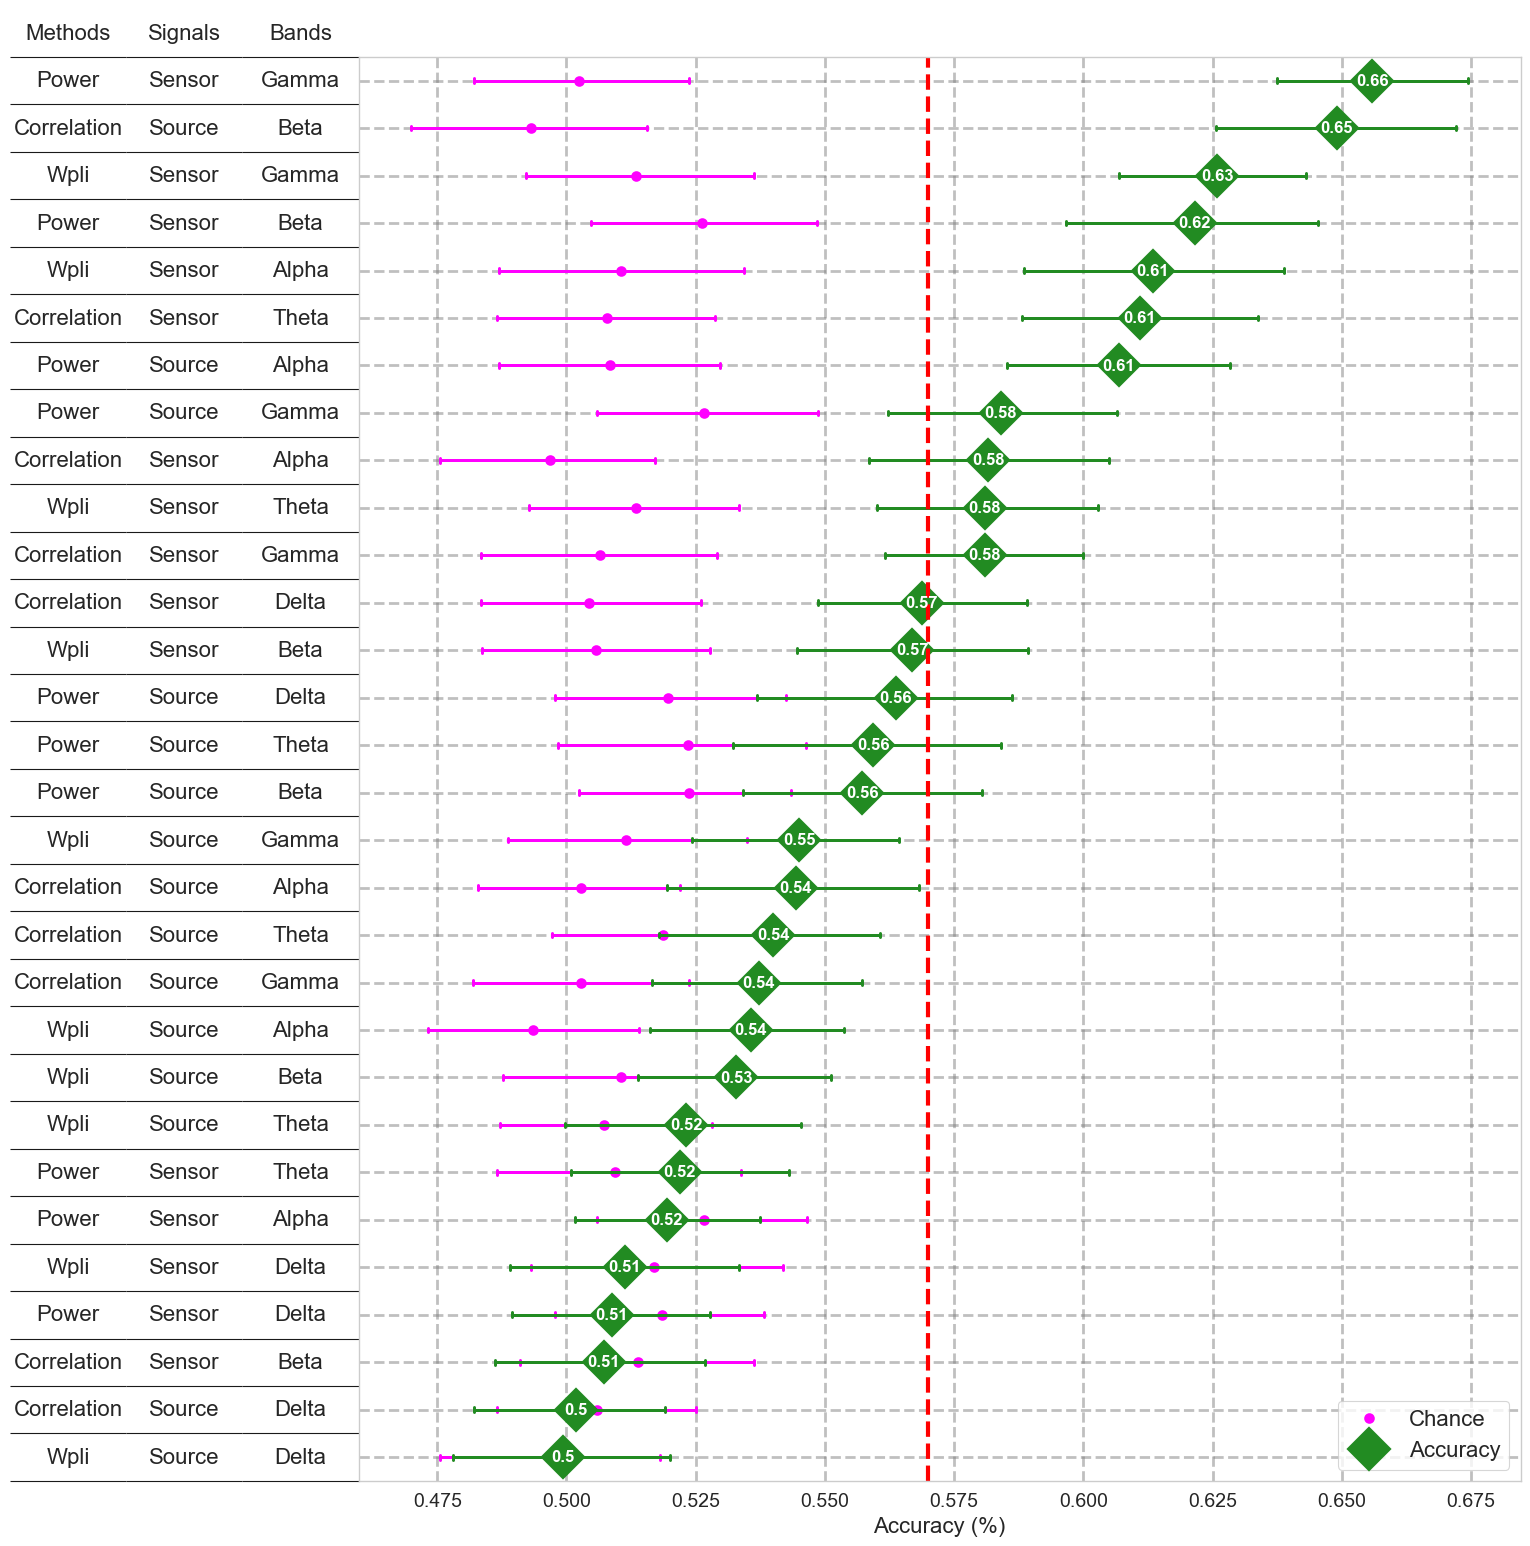

In [4]:
acc = pd.read_csv('data/classification_results/fine_tuned/acc.csv', index_col=0)
acc_rnd = pd.read_csv('data/classification_results/fine_tuned/acc_rnd.csv', index_col=0)

sns.set(style="whitegrid")
sns.set_context("paper")
plot_grid(acc, acc_rnd, markersize=21, figsize=(14,16), n_boot=5000, errorbar=('ci', 99),
          plot_table=True)

### model agnosis explanation

In [27]:
# open c parameters to find the best c for chance model
c_rnd_df = pd.read_csv('data/classification_results/fine_tuned/C.csv', index_col=0)

# CV
CV_EXPLAIN = StratifiedGroupKFold(n_splits=5, shuffle=True)
n_iterations = 40

# models
models = [('power sensor', 'gamma'),
        #   ('correlation source', 'beta')
          ]

# containers
shap_values = {}
y_tests = {}
y_preds = {}
test_indices = {}

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor(power_types='absolute')),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
('clf', SVC(max_iter=1000000, kernel='linear')),
])

In [28]:
for m in models:
    
    # set params
    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    C_model = c_rnd_df.mean()[model_name]
    params = {
        'extract__kind': kind,
        'extract__frequency_band': frequency_band,
        'clf__C': C_model,
    }
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    pipe.set_params(**params)

    # fit model
    X_t = pipe[:-1].fit_transform(X, y)
    feature_names = pipe[:-1].get_feature_names_out()
    model_shapes = []
    _test_indices = []
    y_test_cv = []
    y_pred_cv = []

    for iter in tqdm(range(n_iterations), desc=model_name):
        for train, test in CV_EXPLAIN.split(X, y, groups=groups):

            model = pipe[-1:].fit(X_t[train], y[train])
            y_pred = model.predict(X_t[test])
            
            _test_indices.extend(test)
            y_test_cv.append(y[test])
            y_pred_cv.append(y_pred)
            
            explainer = shap.Explainer(model.predict, X_t[train], feature_names=feature_names)
            cv_shap_values = explainer(X_t[test], max_evals=len(feature_names)*2+1)
            model_shapes.append(cv_shap_values)
    
    shap_values[model_name] = shap.Explanation(
        values=np.vstack([sh.values for sh in model_shapes]),
        base_values=np.hstack([sh.base_values for sh in model_shapes]),
        data=np.vstack([sh.data for sh in model_shapes]),
        feature_names=feature_names,
        output_indexes=None,
        output_names=['low', 'high']
    )

# # pickle shap values
# import pickle
# with open('data/classification_results/fine_tuned/shap_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)

>>>>>>>>>>>>>>>>>power sensor (gamma)<<<<<<<<<<<<<<<<<<


power sensor (gamma): 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


#### SHAP visualization

In [12]:
with open('data/classification_results/fine_tuned/shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

shap_values['power sensor (gamma)'].values.mean(axis=1).max()

0.033364226135310475

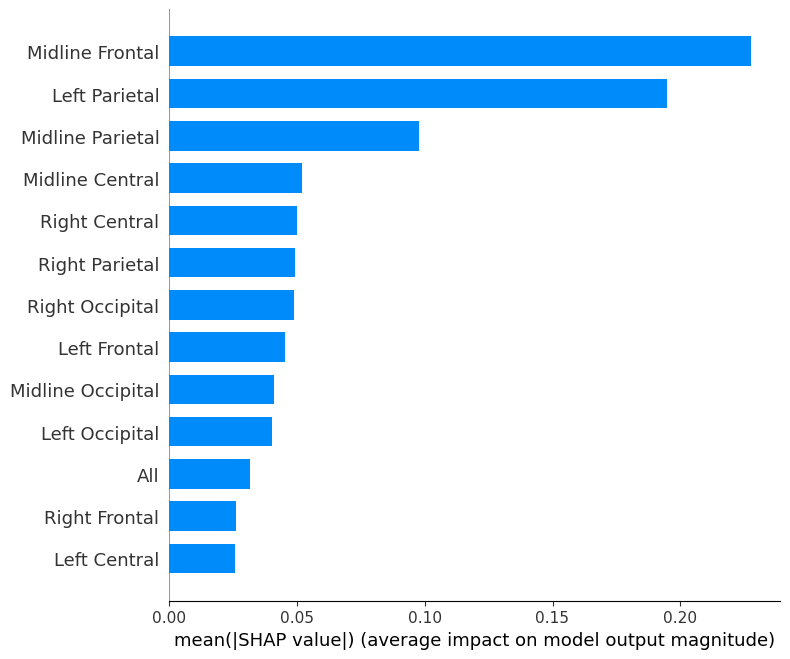

In [54]:
# # open pickled shap
# with open('data/classification_results/fine_tuned/shap_values.pkl', 'rb') as f:
#     shap_values = pickle.load(f)

shap_values['power sensor (gamma)'].feature_names = ['Midline Central',
 'Midline Frontal',
 'Left Central',
 'Left Frontal',
 'Left Occipital',
 'Left Parietal',
 'Midline Occipital',
 'Midline Parietal',
 'Right Central',
 'Right Frontal',
 'Right Occipital',
 'Right Parietal',
 'All'
 ]

# shap_values['correlation source (beta)'].feature_names = [n[:-7] for n in
#                                                           shap_values['correlation source (beta)'].feature_names]

shap.summary_plot(shap_values['power sensor (gamma)'], plot_type='bar', max_display=15)

### Regression Inference


In [65]:
acc = pd.read_csv('data/classification_results/fine_tuned/acc.csv', index_col=0)
acc = acc.melt()
acc[['method', 'signal_type', 'band']] = acc['variable'].str.split(' ', expand=True)
acc = acc.drop('variable', axis=1)
acc['band'] = acc['band'].str.replace('(', '')
acc['band'] = acc['band'].str.replace(')', '')
acc.rename(columns={'value': 'accuracy'}, inplace=True)

In [72]:
# Using statsmodels formula API to fit the linear model
model = smf.ols(formula="accuracy ~ signal_type * method + band", data=acc).fit()

# Displaying the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     24.08
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           1.42e-39
Time:                        20:13:35   Log-Likelihood:                 2006.3
No. Observations:                2100   AIC:                            -3993.
Df Residuals:                    2090   BIC:                            -3936.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.5667      0.006     88.014      0.000       0.554       0.579
signal_type[T.source]                    -0.0027      0.007     -0.386      0.700      -0.017       0.011
method[T.power]                           0.0129      0.007      1.833      0.067      -0.001       0.027
method[T.wpli]                            0.0151      0.007      2.139      0.033       0.001       0.029
band[T.beta]                              0.0107      0.006      1.661      0.097      -0.002       0.023
band[T.delta]                            -0.0328      0.006     -5.094      0.000      -0.045      -0.020
band[T.gamma]                             0.0296      0.006      4.598      0.000       0.017       0.042
band[T.theta]                          -6.24e-05      0.006     -0.010      0.992      -0.013       0.013
signal_type[T.source]:method[T.power]     0.0011      0.010      0.114      0.909      -0.018       0.021
signal_type[T.source]:method[T.wpli]     -0.0615      0.010     -6.170      0.000      -0.081      -0.042
==============================================================================
Omnibus:                       15.858   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.219
Skew:                          -0.167   Prob(JB):                     0.000182
Kurtosis:                       3.293   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Without hyperparameter tuning

In [18]:
kinds = ['power sensor']
frequency_bands = ['theta', 'alpha', 'beta']
models = [(i, j) for i in kinds for j in frequency_bands]

cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}
y_preds = []

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=50, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)


for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    power_types = 'decibel'
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
        'extract__power_types': [power_types],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

pd.DataFrame(models_test_accuraies).mean()  
# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>power sensor (theta)<<<<<<<<<<<<<<<<<<


 33%|███▎      | 1/3 [00:04<00:09,  4.53s/it]

>>>>>>>>>>>>>>>>>power sensor (alpha)<<<<<<<<<<<<<<<<<<


 67%|██████▋   | 2/3 [00:08<00:04,  4.37s/it]

>>>>>>>>>>>>>>>>>power sensor (beta)<<<<<<<<<<<<<<<<<<


100%|██████████| 3/3 [00:13<00:00,  4.33s/it]


0.4739516129032259

### Significancy test
#### permutation test

In [23]:
from sklearn.model_selection import permutation_test_score

In [48]:
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'correlation sensor', 'wpli source',
         'wpli sensor', 'power source', 'power sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

CHANCE_CV = GroupShuffleSplit(n_splits=5, test_size=0.2)

In [ ]:
## permutation + no nested
perm_scores = {}

for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    pipe = Pipeline([
            ('extract', FeatureExtractor(kind=kind, frequency_band=frequency_band)),
            ('zerovar', VarianceThreshold(threshold=0.0)),
            ('scale', StandardScaler()),
            ('clf', SVC(kernel='linear'))
        ])


    perm_score = permutation_test_score(pipe, X, y, cv=CHANCE_CV, scoring='accuracy',
                                         n_permutations=100, n_jobs=-1, verbose=0,
                                         groups=groups)
    
    perm_scores[model_name] = perm_score

chance_scores = {k:v[1] for k,v in perm_scores.items()}
# pd.DataFrame(chance_scores).to_csv('data/classification_results/chance model/perm_score.csv')
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

In [69]:
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv', index_col=0)

# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()

# chance score
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

#### manual permutation test

In [42]:
import random
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'correlation sensor', 'wpli source',
         'wpli sensor', 'power source', 'power sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

In [ ]:
# chance score
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}
y_preds = []

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=50, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)


for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    
    for train, test in outer_cv.split(X, y, groups):
        random.shuffle(y)

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/chance model/perm_score_manually_shuffled.csv')

#### Visualization

In [4]:
# open grid results
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv', index_col=0)

# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()
uniques = grid_results.groupby('variable').mean().sort_values(by='value', ascending=False)

# open chance scores
chance_scores = pd.read_csv('data/classification_results/chance model/perm_score_manually_shuffled.csv', index_col=0)
chance_scores = chance_scores.melt(var_name='label', value_name='test_score')

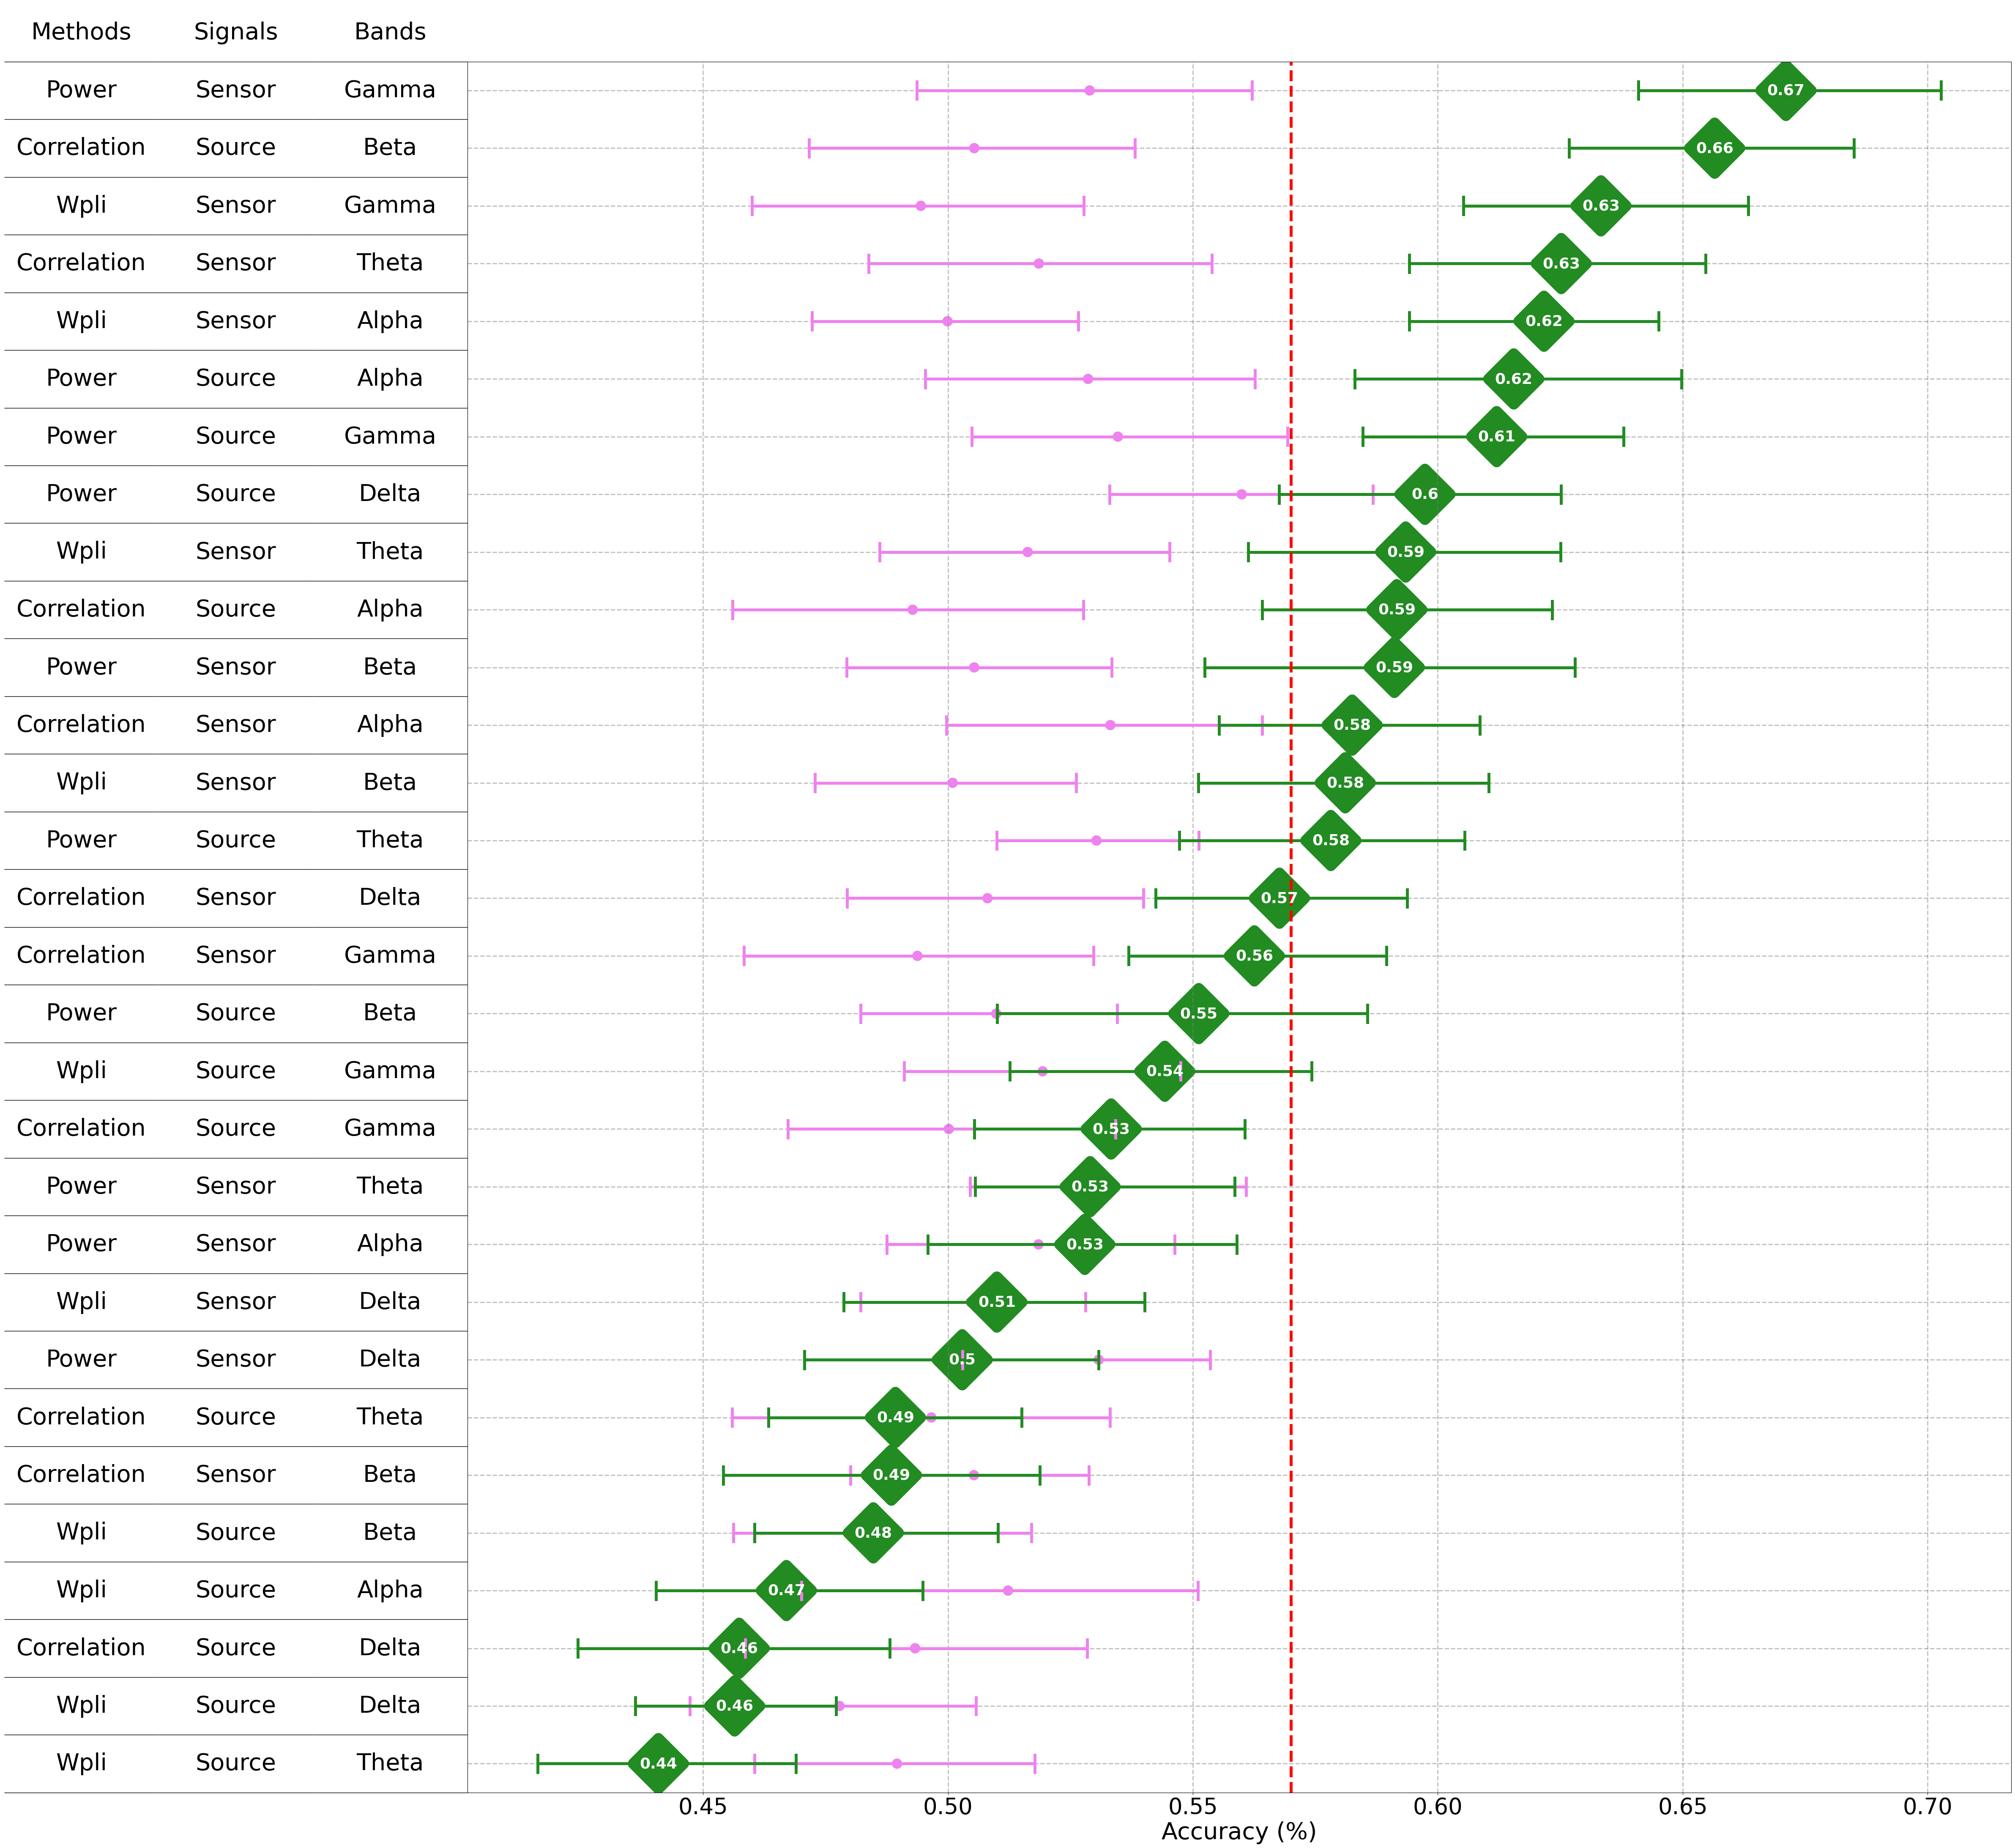

In [36]:
order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

fig, ax = plt.subplots(1, 1, figsize=(44, 46))

# plot chance
# sns.boxplot(data=chance_scores, x='test_score', y='label', saturation=1, orient='h', order=order)
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='violet', linestyles='dotted', scale=2, capsize=0.3, errwidth=5,
              join=False, 
              label='Chance',
              dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# plot observed
# sns.stripplot(data=grid_results, x='value', y='variable', orient='h', order=order)
g = sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h', markers='D',
              color='forestgreen', scale=9, capsize=0.3, errwidth=5, join=False,
              label='Accuracy',
              dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# annotate points
yticks = [tick.get_text() for tick in g.get_yticklabels()]
for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
    y = yticks.index(y_txt)
    t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                 fontdict={'color':'white', 'size':26, 'weight':'bold'})

plt.axvline(0.57, color='r', linestyle='--', linewidth=5)

# ----------------- table -----------------
table_content = [i.split(' ') for i in uniques.index]
table_content = [[re.sub(r'[()]', '', j).capitalize() for j in i] for i in table_content]
col = ['Methods', 'Signals', 'Bands']
n = len(table_content)

# Plot
fig.subplots_adjust(left=0.07,
                    top=1
                    )

table = ax.table(cellText=table_content,
                     colLabels=col,
                     cellLoc='center',
                     colColours =["palegreen"]*3,
                     bbox=(-0.3, 0.0, 0.3, (n+1) / n),
                     edges='B',
                     )

table.auto_set_font_size(False)
table.set_fontsize(40)

fig.canvas.draw()   # need to draw the figure twice
plt.xticks(fontsize=38)
plt.xlabel('Accuracy (%)', fontsize=40)
plt.ylabel('')
plt.yticks([])
# plt.title('SVM Validation Accuracy (100x 5-fold CV)', fontsize=60)
# plt.legend(loc="upper left")

# add grid to the categorical y axis
for y in np.arange(0, n, 1):
    ax.axhline(y, linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)
    
plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)

plt.show()

### model agnosis explanation

In [ ]:
CV_EXPLAIN = StratifiedGroupKFold(n_splits=5, shuffle=True)
n_iterations = 40

models = [('power sensor', 'gamma'),
        #   ('correlation source', 'beta')
          ]
shap_values = {}
y_tests = {}
y_preds = {}
test_indices = {}

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor()),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
('clf', SVC(max_iter=1000000, kernel='linear')),
])


for m in models:
    
    # set params
    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    params = {
        'extract__kind': kind,
        'extract__frequency_band': frequency_band,
    }
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    pipe.set_params(**params)

    # fit model
    X_t = pipe[:-1].fit_transform(X, y)
    feature_names = pipe[:-1].get_feature_names_out()
    model_shapes = []
    _test_indices = []
    y_test_cv = []
    y_pred_cv = []

    for iter in tqdm(range(n_iterations), desc=model_name):
        for train, test in CV_EXPLAIN.split(X, y, groups=groups):

            model = pipe[-2:].fit(X_t[train], y[train])
            y_pred = model.predict(X_t[test])
            
            _test_indices.extend(test)
            y_test_cv.append(y[test])
            y_pred_cv.append(y_pred)
            
            explainer = shap.Explainer(model.predict, X_t[train], feature_names=feature_names)
            cv_shap_values = explainer(X_t[test], max_evals=len(feature_names)*2+1)
            model_shapes.append(cv_shap_values)
            
    
    y_tests[model_name] = np.hstack(y_test_cv)
    y_preds[model_name] = np.hstack(y_pred_cv)
    test_indices[model_name] = np.array(_test_indices)
    
    shap_values[model_name] = shap.Explanation(
        values=np.vstack([sh.values for sh in model_shapes]),
        base_values=np.hstack([sh.base_values for sh in model_shapes]),
        data=np.vstack([sh.data for sh in model_shapes]),
        feature_names=feature_names,
        output_indexes=y_pred,
        output_names=['low', 'high']
    )
    
# shap_values = shap_values[model_name]

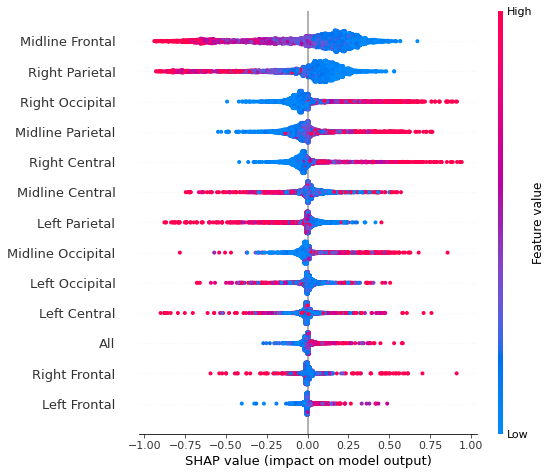

In [11]:
shap_values['power sensor (gamma)'].feature_names = ['Midline Central',
 'Midline Frontal',
 'Left Central',
 'Left Frontal',
 'Left Occipital',
 'Left Parietal',
 'Midline Occipital',
 'Midline Parietal',
 'Right Central',
 'Right Frontal',
 'Right Occipital',
 'Right Parietal',
 'All'
 ]
shap.summary_plot(shap_values['power sensor (gamma)'], plot_type='dot', max_display=15)

## Experimenting:
classification with real hypnosis sessions, regardless of their lables.

In [95]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('condition.str.contains("experience")')
# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('not procedure.str.contains("embedded")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [96]:
# 2. PIPELINE
pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

# CV method
CV = GroupShuffleSplit(n_splits=100, test_size=0.2)

# 3. Grid Search
grid_params = [{
    'extract__kind': ['correlation source', 'power source', 'power sensor',
                      'wpli source'],
    'extract__frequency_band': ['delta', 'theta', 'alpha', 'beta', 'gamma'],
}]

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X, y, groups=groups)

Fitting 100 folds for each of 20 candidates, totalling 2000 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=100, random_state=None, test_size=0.2,
         train_size=None),
             estimator=Pipeline(steps=[('extract', FeatureExtractor()),
                                       ('zerovar', VarianceThreshold()),
                                       ('scale', StandardScaler()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            kernel='linear',
                                            max_iter=1000000))]),
             n_jobs=-1,
             param_grid=[{'extract__frequency_band': ['delta', 'theta', 'alpha',
                                                      'beta', 'gamma'],
                          'extract__kind': ['correlation source',
                                            'power source', 'power sensor',
                                            'wpli source']}],
             scoring='accuracy', verbose=1)

In [97]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CV, scoring='accuracy', n_jobs=-1)
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[model_name] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

Text(0, 0.5, 'Dataset')

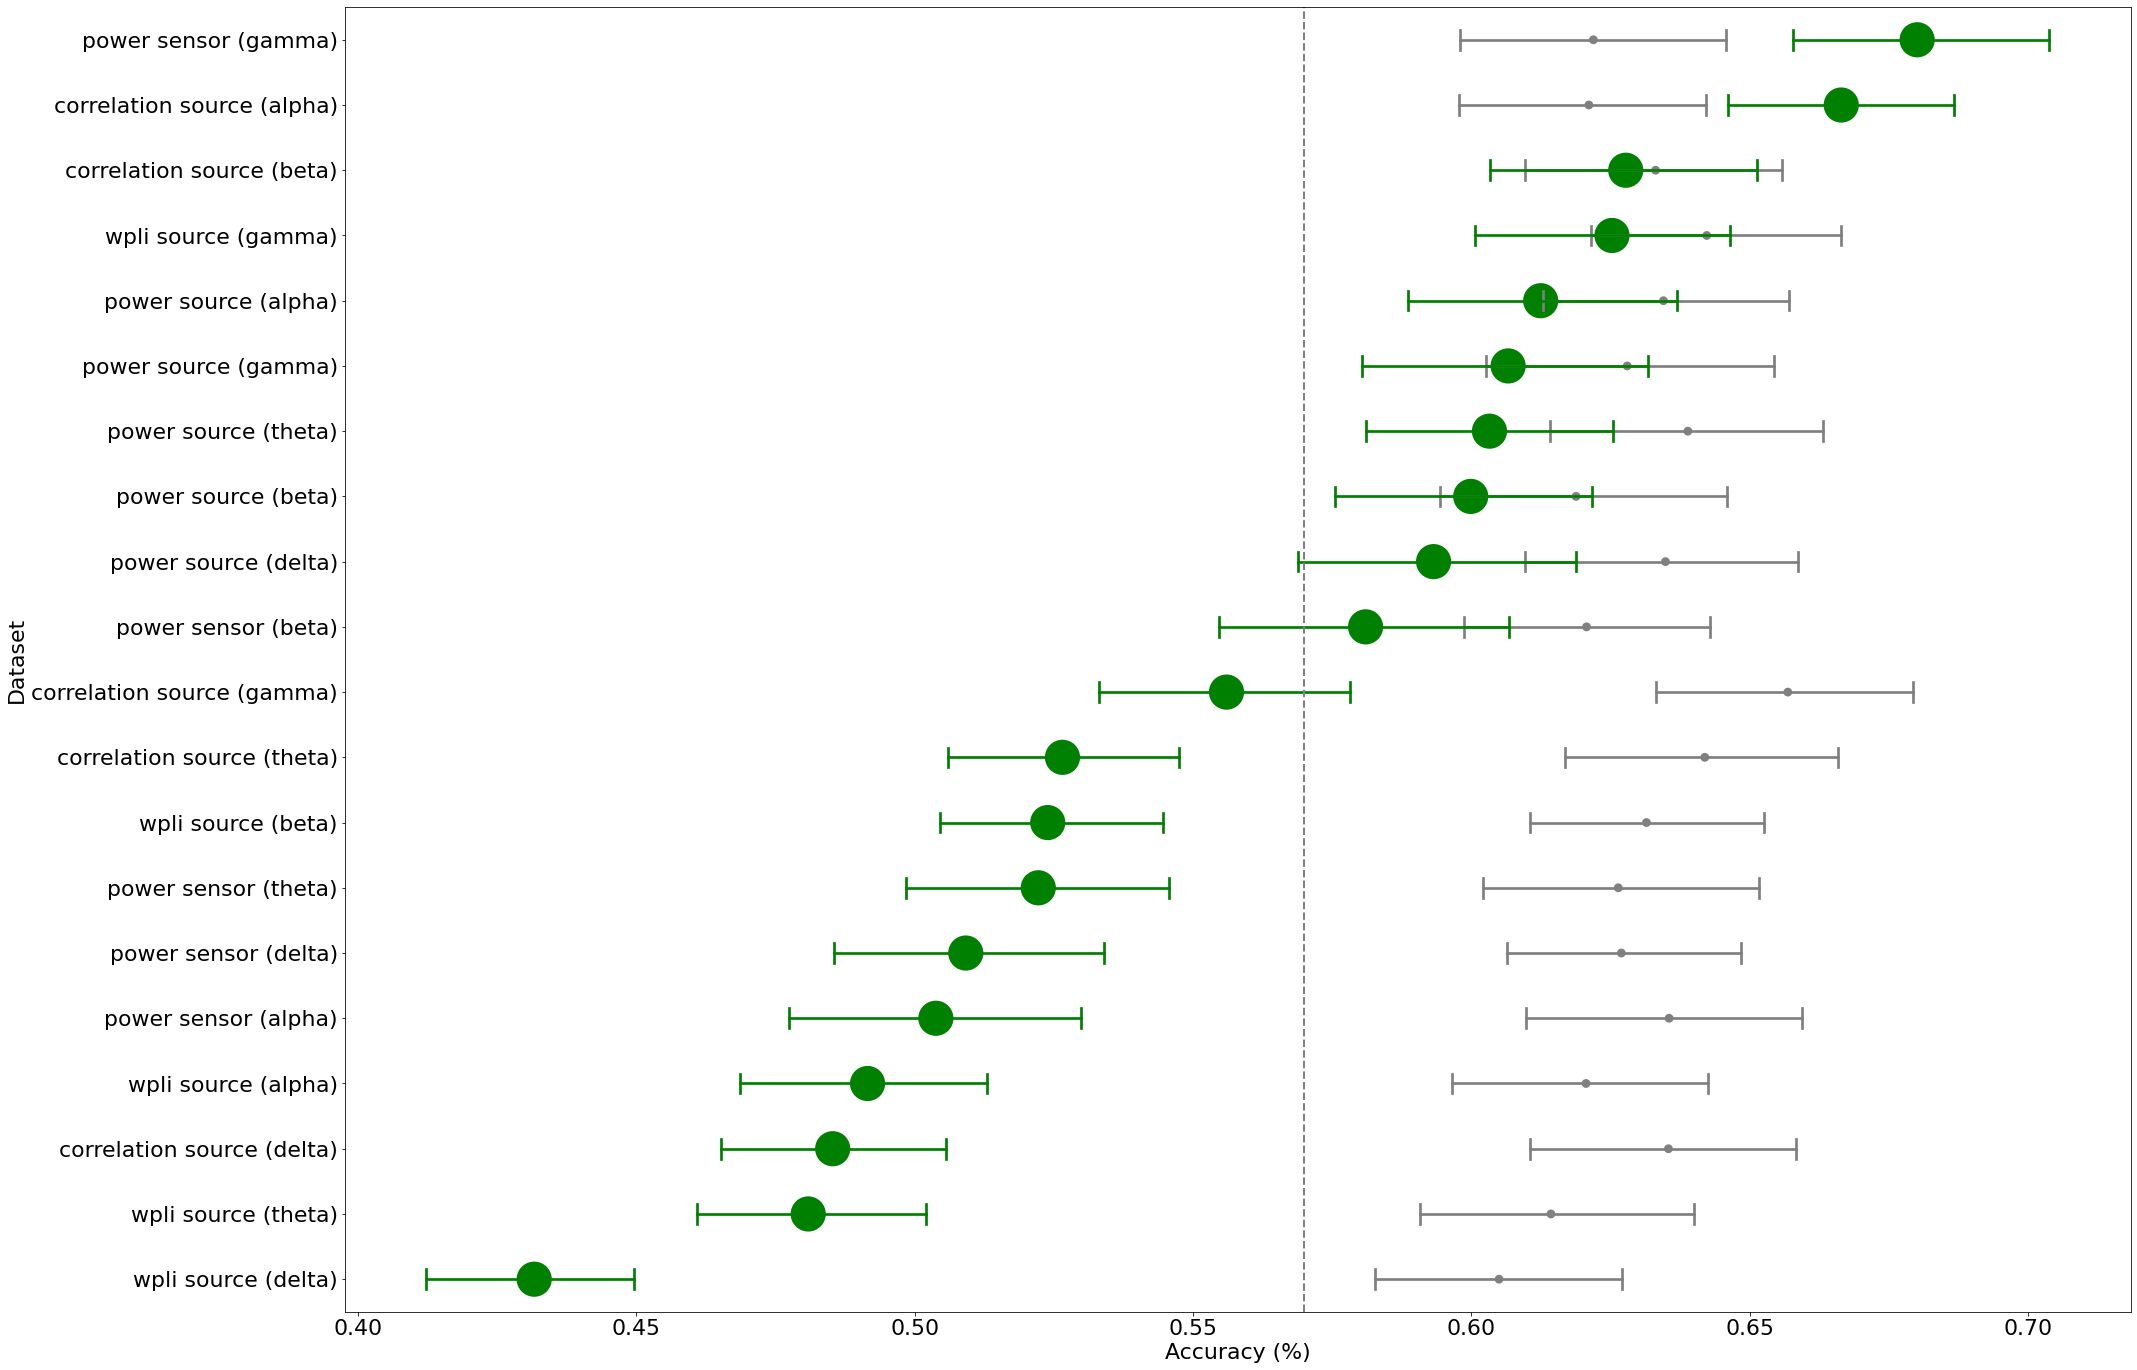

In [98]:
_, ax = plt.subplots(1, 1, figsize=(32, 24))
order = grid_results.groupby('label')['test_score'].mean().sort_values(ascending=False).index.values

# plot chance
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='gray', scale=1, capsize=0.3, join=False, label='Chance', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label', order=order, orient='h',
              color='green', scale=4, capsize=0.3, join=False, label='Accuracy', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# Add horizontal line indicating the baseline value
plt.axvline(0.57, color='grey', linestyle='--', linewidth=2)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel('Accuracy (%)', fontsize=22)
plt.ylabel('Dataset', fontsize=22)

In [15]:
import pickle

# open shap data 
with open('data/classification_results/shap_values.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]
test_indices_keys = list(_shap_values.keys())[9:12]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'
test_indices = {k[len('test_indices_'):]:_shap_values[k] for k in test_indices_keys} # remove 'test_indices_'

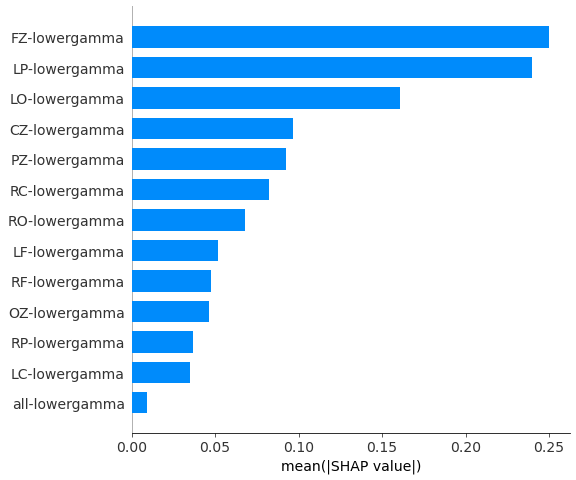

In [17]:
import shap
import matplotlib.pyplot as plt
model_name = 'power sensor (gamma)'
shap.summary_plot(shap_values[model_name], plot_type='bar', max_display=13, show=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.show()

## Select from model
We have many features when it comes to sensor connectivity. In this case, We would use `SelectFromModel` to select the top features from the model. In this first step, let's take a look at how many features will be selected in the correlation sensor dataset when we use `SelectFromModel` with a `LinearSVC` model.

In [125]:
from sklearn.svm import SVC
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GroupShuffleSplit
 
DATA = pd.read_csv('data/classification_datasets/correlation_sensor.csv', index_col=0)
# choose only the experience conditions where hypnosis is describe as hypnosis
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)

y_ = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)
cols = [c for c in DATA.columns if 'gamma' in c]
X_ = DATA[cols]
print(f'number of features before applying model selection: {X_.shape[1]}')

train, test = next(GroupShuffleSplit(test_size=.2).split(X, y, groups=DATA['bids_id']))

lsvc = SVC(C=1, kernel="linear").fit(X_.iloc[train], y_.iloc[train])
model = SelectFromModel(lsvc, threshold='mean')
X_new = model.transform(X_)
print(f'number of features after applying model selection: {X_new.shape[1]}')

number of features before applying model selection: 1596
number of features after applying model selection: 668


/opt/homebrew/Caskroom/miniforge/base/envs/b2bnet/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


So, if we use threshold=mean in SelectFromModel, less than half of the features are selected in correlation sensor dataset (gamma). let's see how it would affect the classification:

In [146]:
y_preds = []
grid_results = pd.DataFrame()

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=30, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor()),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
('select', SelectFromModel(estimator=SVC(max_iter=1000000, kernel="linear"), threshold='median')),
('clf', SVC(max_iter=1000000, kernel='linear')),
])

# grid search
grid_params = [{
    'extract__kind': ['correlation sensor'],
    'extract__frequency_band': ['theta'],
    'select' : [SelectFromModel(estimator=SVC(max_iter=1000000, kernel="linear"), threshold='median'), 'passthrough'],
}]

test_accuraies = []
for train, test in outer_cv.split(X, y, groups):

    # Nested CV with parameter optimization
    grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(X[train], y[train], groups=groups.iloc[train])
    grid_result = pd.DataFrame(grid.cv_results_)
    grid_results = pd.concat([grid_results, grid_result], axis=0)
    
    # accrucy on the test set using the best estimator
    y_pred = grid.predict(X[test])
    y_preds.append(y_pred)
    test_accuraies.append((y[test] == y_pred).mean())

In [147]:
print(f'mean of test accuracies: {np.array(test_accuraies).mean()}')

mean of test accuracies: 0.6270833333333334


So it seems that the classification is  significantly improved by using `SelectFromModel` with `LinearSVC` model, since the mean accuracy of the test scores is about 0.56 when there is no select from model.
It's important to note that while incorporating `SelectFromModel` into the pipeline would improve the classification accuracy in one dataset *corrleation sensor (gamma)*, it might not be the case for other datasets *correlation sensor (theta)*. So, it's better to use `SelectFromModel` with `LinearSVC` model in a nested cross-validation to see if it would improve the classification accuracy or not.